In [8]:
# Google Colab Setup
try:
    import google.colab
    import os
    import sys
    
    print("Running in Google Colab")
    
    # Define base path
    base_path = '/content'
    
    # Create project structure
    src_path = os.path.join(base_path, 'src')
    data_root = os.path.join(src_path, 'data')
    notebooks_path = os.path.join(base_path, 'notebooks')
    
    os.makedirs(data_root, exist_ok=True)
    os.makedirs(notebooks_path, exist_ok=True)
    
    # Install requirements
    if os.path.exists(os.path.join(base_path, 'requirements.txt')):
        print("Installing requirements...")
        !pip install -q -r requirements.txt
        
    # Download dataset
    print("Downloading Flowers102 dataset...")
    from torchvision.datasets import Flowers102
    try:
        Flowers102(root=data_root, split='train', download=True)
        Flowers102(root=data_root, split='val', download=True)
        Flowers102(root=data_root, split='test', download=True)
        print("Dataset downloaded.")
    except Exception as e:
        print(f"Dataset download failed: {e}")
    
    # Change directory to notebooks
    if os.path.exists(notebooks_path):
        os.chdir(notebooks_path)
        print(f"Changed directory to {notebooks_path}")
        
    # Add project root to sys.path so imports work
    project_root = base_path
    if project_root not in sys.path:
        sys.path.append(project_root)
        print(f"Added {project_root} to sys.path")

except ImportError:
    # Local Machine Setup
    import os
    import sys
    
    print("Running on Local Machine")
    
    # Get the path to the project root (assuming running from notebooks/)
    current_dir = os.getcwd()
    if current_dir.endswith('notebooks'):
        project_root = os.path.abspath('..')
    else:
        project_root = os.path.abspath('.')
    
    if os.path.exists(os.path.join(project_root, 'src')):
         if project_root not in sys.path:
            sys.path.append(project_root)
            print(f"Added project root to sys.path: {project_root}")


Running on Local Machine


# Model Training

This notebook handles the training of the ResNet50 model using Transfer Learning. 
It includes data loading, model initialization, validation-based early stopping, and metric logging.

In [9]:
import os
# --- Inlined src/data/transforms.py ---

from torchvision import transforms

from PIL import Image, ImageOps

class ResizeWithPad:
    """
    Resizes the image to the target size by maintaining aspect ratio
    and adding white padding (letterboxing) to fit the square.
    """
    def __init__(self, size, fill=(255, 255, 255)):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        target_size = (self.size, self.size)
        
        # Copy image to avoid in-place modification issues
        img = img.copy()
        
        # Resize maintaining aspect ratio (thumbnail max dimension is size)
        img.thumbnail(target_size, Image.Resampling.LANCZOS)
        
        # Calculate padding
        delta_w = self.size - img.size[0]
        delta_h = self.size - img.size[1]
        
        # (left, top, right, bottom)
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
        
        return ImageOps.expand(img, padding, fill=self.fill)

def get_transforms(phase='train', image_size=416):
    """
    Returns the data transforms for the specified phase.
    
    Args:
        phase (str): 'train' or 'val'/'test'
        image_size (int): Target input size (default 640)
    """
    # ImageNet normalization stats
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if phase == 'train':
        return transforms.Compose([
            ResizeWithPad(image_size),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    else:
        return transforms.Compose([
            ResizeWithPad(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])


# --- Inlined src/data/loader.py ---

import torch
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader, Dataset

def create_dataloaders(data_dir='./src/data', batch_size=32, num_workers=0 if os.name == 'nt' else 2):
    """
    Creates DataLoaders for train, validation, and test sets.
    Uses the official Flowers102 splits but ensures transforms are applied.
    """
    
    # Define transforms
    train_transform = get_transforms('train')
    val_test_transform = get_transforms('val')

    # Load datasets
    # Note: Flowers102 'train' set is smaller (10 images per class), 
    # 'test' is larger (min 20 per class). 
    # Usually we merge and re-split if we want a standard larger train set, 
    # but strictly adhering to the dataset often means using its defined splits.
    # However, for better deep learning training, it's common to use 'train' + 'val' for training 
    # if the official 'train' is too small, OR just use the official splits.
    # Let's stick to official splits first as per "Data Integrity" rule implies using the dataset via torchvision.
    
    train_dataset = Flowers102(root=data_dir, split='train', download=True, transform=train_transform)
    val_dataset = Flowers102(root=data_dir, split='val', download=True, transform=val_test_transform)
    test_dataset = Flowers102(root=data_dir, split='test', download=True, transform=val_test_transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader


In [10]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import models, transforms
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import Flowers102
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torchvision.transforms.functional as TF
import torch.nn.functional as F

# Add src to path (still useful)
sys.path.append(os.path.abspath('../'))

# --- Inlined src/utils/seeds.py ---
def set_seeds(seed=42):
    """
    Sets the random seed for reproducibility.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Global seed set to {seed}")

# --- Inlined src/models/base_model.py ---
def get_model(num_classes=102, fine_tune=True):
    """
    Loads a pre-trained ResNet50 and replaces the final layer.
    """
    try:
        from torchvision.models import ResNet50_Weights
        weights = ResNet50_Weights.IMAGENET1K_V1
        model = models.resnet50(weights=weights)
    except ImportError:
        model = models.resnet50(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# --- Inlined src/data/transforms.py ---
class ResizeWithPad:
    def __init__(self, size, fill=(255, 255, 255)):
        self.size = size
        self.fill = fill
    def __call__(self, img):
        target_size = (self.size, self.size)
        img = img.copy()
        img.thumbnail(target_size, Image.Resampling.LANCZOS)
        delta_w = self.size - img.size[0]
        delta_h = self.size - img.size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
        return ImageOps.expand(img, padding, fill=self.fill)

def get_transforms(phase='train', image_size=640):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    if phase == 'train':
        return transforms.Compose([
            ResizeWithPad(image_size),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    else:
        return transforms.Compose([
            ResizeWithPad(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

# --- Inlined src/data/loader.py ---
def create_dataloaders(data_dir='./src/data', batch_size=32, num_workers=0 if os.name == 'nt' else 2):
    train_transform = get_transforms('train')
    val_test_transform = get_transforms('val')
    train_dataset = Flowers102(root=data_dir, split='train', download=True, transform=train_transform)
    val_dataset = Flowers102(root=data_dir, split='val', download=True, transform=val_test_transform)
    test_dataset = Flowers102(root=data_dir, split='test', download=True, transform=val_test_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader, test_loader

# --- Inlined src/training/trainer.py ---
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    return epoch_loss, epoch_acc.item()

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
    val_loss = running_loss / total_samples
    val_acc = running_corrects.double() / total_samples
    return val_loss, val_acc.item()

def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, early_stopping=None):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
    print(f"Training on {device}")
    for epoch in range(num_epochs):
        start = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        duration = time.time() - start
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {duration:.0f}s")
        print(f"  Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} LR: {current_lr:.6f}")
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered")
                break
    if early_stopping:
        model.load_state_dict(torch.load(early_stopping.path))
    return model, history

# --- Inlined src/training/callbacks.py ---
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

set_seeds(42)

Global seed set to 42


## Configuration & Hyperparameters

In [11]:
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


## Data Loading

In [12]:
train_loader, val_loader, test_loader = create_dataloaders(data_dir='../src/data', batch_size=BATCH_SIZE)

## Model Initialization
We use ResNet50. Initially, only the final fully connected layer is trainable.

In [13]:
model = get_model(num_classes=102)
model = model.to(DEVICE)

## Training Setup
1. **Criterion**: CrossEntropyLoss (suited for multi-class classification).
2. **Optimizer**: Adam (widely used, good convergence). 
   *Note: Only optimizing `model.fc.parameters()` initially since backbone is frozen.*
3. **Scheduler**: ReduceLROnPlateau (decays LR when validation loss stalls).
4. **Early Stopping**: Stops training if no improvement for 5 epochs.

In [14]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - ONLY parameters that require gradients
params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params_to_update, lr=LEARNING_RATE)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Early Stopping
early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model.pt')

## Training Loop

In [15]:
model, history = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    NUM_EPOCHS,
    DEVICE,
    early_stopping
)

Training on cpu
Epoch 1/20 - Time: 363s
  Train Loss: 5.0512 Acc: 0.0167
  Val Loss: 4.3572 Acc: 0.0225 LR: 0.001000
Validation loss decreased (inf --> 4.357158).  Saving model ...
Epoch 2/20 - Time: 388s
  Train Loss: 4.1391 Acc: 0.1186
  Val Loss: 3.8211 Acc: 0.1392 LR: 0.001000
Validation loss decreased (4.357158 --> 3.821105).  Saving model ...
Epoch 3/20 - Time: 499s
  Train Loss: 3.5537 Acc: 0.2745
  Val Loss: 3.3450 Acc: 0.3304 LR: 0.001000
Validation loss decreased (3.821105 --> 3.345024).  Saving model ...
Epoch 4/20 - Time: 509s
  Train Loss: 3.0576 Acc: 0.4088
  Val Loss: 2.9224 Acc: 0.3892 LR: 0.001000
Validation loss decreased (3.345024 --> 2.922441).  Saving model ...
Epoch 5/20 - Time: 486s
  Train Loss: 2.5684 Acc: 0.5676
  Val Loss: 2.5800 Acc: 0.5039 LR: 0.001000
Validation loss decreased (2.922441 --> 2.579954).  Saving model ...
Epoch 6/20 - Time: 486s
  Train Loss: 2.2058 Acc: 0.6529
  Val Loss: 2.2950 Acc: 0.5618 LR: 0.001000
Validation loss decreased (2.579954 --

## Training History Visualization

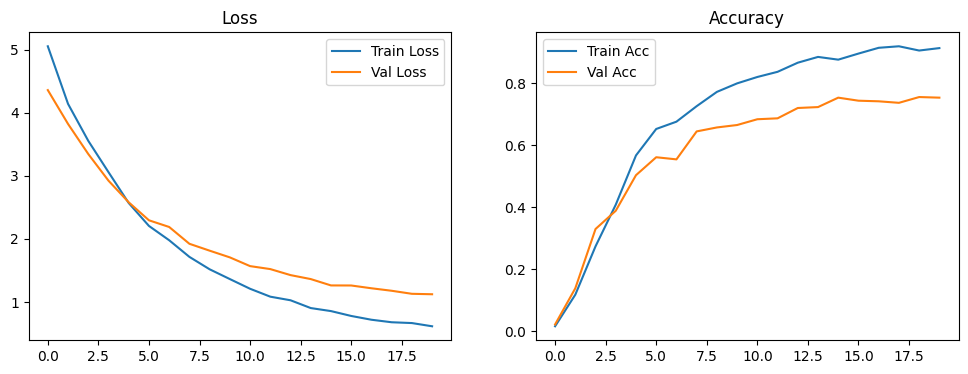

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.show()


# Part 2: Fine Tuning
---
The following content is merged from `04_Fine_Tuning.ipynb`.


# Fine-Tuning (Unfreezing Backbone)

In this notebook, we will load the previously trained model (`best_model.pt`), unfreeze the backbone (ResNet50), and fine-tune it with a lower learning rate. This usually improves performance on granular tasks like flower classification.

In [17]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Add src to path
sys.path.append(os.path.abspath('../'))

from src.data.loader import create_dataloaders
from src.models.base_model import get_model
from src.training.trainer import fit
from src.training.callbacks import EarlyStopping
from src.utils.seeds import set_seeds

# Set seeds for reproducibility
set_seeds(42)

Global seed set to 42


## 1. Setup Environment

In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8 # Reduced batch size for 640x640 resolution to avoid OOM
NUM_EPOCHS = 15
LEARNING_RATE = 1e-5 # Lower learning rate for fine-tuning

print(f"Using device: {DEVICE}")

Using device: cpu


## 2. Load Data

In [19]:
train_loader, val_loader, test_loader = create_dataloaders(data_dir='../src/data', batch_size=BATCH_SIZE)

## 3. Load Model and Unfreeze

In [20]:
model = get_model(num_classes=102, fine_tune=False)
model_path = 'best_model.pt'

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    print("Loaded weights from best_model.pt")
else:
    print("Warning: best_model.pt not found. Starting fine-tuning from ImageNet weights (NOT RECOMMENDED without Stage 1).")

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

model = model.to(DEVICE)
print("Model backbone unfrozen.")

Loaded weights from best_model.pt
Model backbone unfrozen.


## 4. Setup Training Components
We use a much smaller learning rate to avoid destroying the pre-trained features.

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model_finetuned.pt')

## 5. Execute Fine-Tuning

In [22]:
model, history = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    NUM_EPOCHS,
    DEVICE,
    early_stopping
)

Training on cpu
Epoch 1/15 - Time: 1500s
  Train Loss: 0.9734 Acc: 0.8716
  Val Loss: 0.8277 Acc: 0.8225 LR: 0.000010
Validation loss decreased (inf --> 0.827702).  Saving model ...
Epoch 2/15 - Time: 1501s
  Train Loss: 0.5952 Acc: 0.9402
  Val Loss: 0.6837 Acc: 0.8471 LR: 0.000010
Validation loss decreased (0.827702 --> 0.683662).  Saving model ...
Epoch 3/15 - Time: 1499s
  Train Loss: 0.4440 Acc: 0.9667
  Val Loss: 0.5811 Acc: 0.8775 LR: 0.000010
Validation loss decreased (0.683662 --> 0.581069).  Saving model ...
Epoch 4/15 - Time: 1499s
  Train Loss: 0.3889 Acc: 0.9647
  Val Loss: 0.5475 Acc: 0.8755 LR: 0.000010
Validation loss decreased (0.581069 --> 0.547460).  Saving model ...
Epoch 5/15 - Time: 1500s
  Train Loss: 0.2954 Acc: 0.9824
  Val Loss: 0.5102 Acc: 0.8824 LR: 0.000010
Validation loss decreased (0.547460 --> 0.510156).  Saving model ...
Epoch 6/15 - Time: 1501s
  Train Loss: 0.2767 Acc: 0.9824
  Val Loss: 0.4813 Acc: 0.8843 LR: 0.000010
Validation loss decreased (0.510

## 6. History Plot

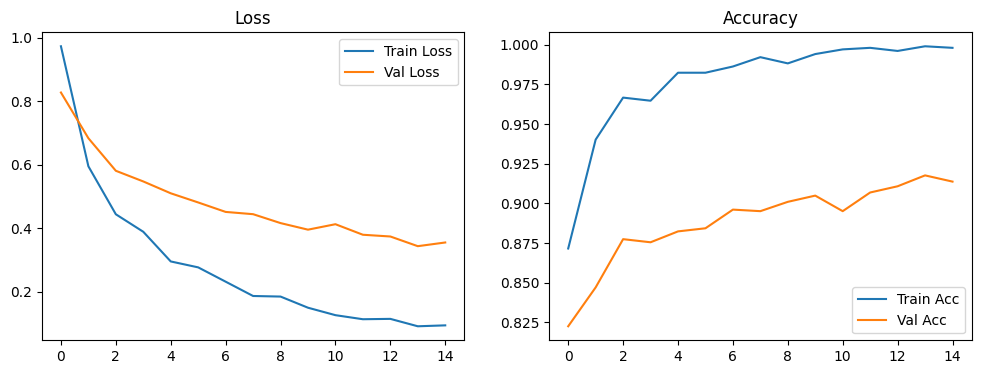

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.show()